### 필요한 library들 설치

In [11]:
!pip install pypianoroll mido MIDIUtil

### Maestro v3.0.0 dataset 다운로드

In [2]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip

--2021-12-26 16:39:38--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.199.112, 142.250.207.16, 142.250.207.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.199.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip.2’

maestro-v3.0.0-midi 100%[===================>]  55.71M  4.01MB/s    in 14s     

2021-12-26 16:39:54 (4.06 MB/s) - ‘maestro-v3.0.0-midi.zip.2’ saved [58416533/58416533]



### 압축 풀기

In [3]:
!unzip -o -qq maestro-v3.0.0-midi.zip

### midi 파일 정보 list에 담기

In [2]:
import csv 

root_dir = 'maestro-v3.0.0/'
midi_list = []
with open(root_dir + 'maestro-v3.0.0.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        midi_info = {'file': root_dir + row[4],
                     'composer': row[0],
                     'title': row[1]}
        midi_list.append(midi_info)
midi_list = midi_list[1:]

for i, midi_info in enumerate(midi_list[:5]):
    print(i, midi_info)

0 {'file': 'maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi', 'composer': 'Alban Berg', 'title': 'Sonata Op. 1'}
1 {'file': 'maestro-v3.0.0/2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.midi', 'composer': 'Alban Berg', 'title': 'Sonata Op. 1'}
2 {'file': 'maestro-v3.0.0/2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.midi', 'composer': 'Alban Berg', 'title': 'Sonata Op. 1'}
3 {'file': 'maestro-v3.0.0/2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01_wav.midi', 'composer': 'Alexander Scriabin', 'title': '24 Preludes Op. 11, No. 13-24'}
4 {'file': 'maestro-v3.0.0/2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_04_Track04_wav.midi', 'composer': 'Alexander Scriabin', 'title': '3 Etudes, Op. 65'}


### Midi file 열어서 pianoroll로 보여주기

[<AxesSubplot:xlabel='time (beat)', ylabel='\n\npitch'>]

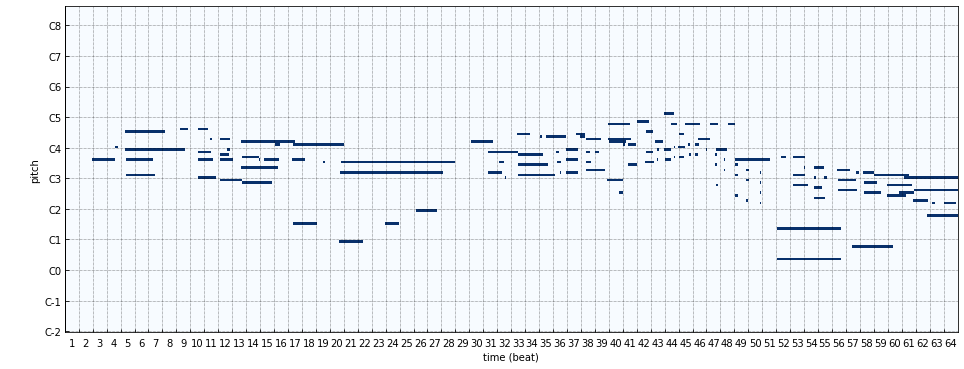

In [3]:
import matplotlib.pyplot as plt
import pypianoroll

multitrack = pypianoroll.read(midi_list[0]['file'])
# 앞에서부터 64박 자름
multitrack.trim(0, 64 * multitrack.resolution)
# Velocity 정보 삭제
multitrack.binarize()
# 보여주기
fig, axs = plt.subplots(nrows=1, figsize=(16, 6))
multitrack.plot(axs=[axs])

### Midi message를 받아 event list로 변환

In [4]:
import mido
import numpy as np

def get_event_list(data_file):
    
    midi_messages = mido.MidiFile(data_file)
    
    current_time = 0
    event_list = []
    pedal_on = False
    
    for message in midi_messages:
        # Accumulate relative times
        current_time += message.time
        
        # 'note_on' 이벤트 발생하고 velocity가 0보다 큰 경우
        if message.type == 'note_on' and message.velocity > 0:
            event = {'time': current_time,
                     'type': 'note_on',
                     'note': message.note,
                     'velocity': message.velocity}
            event_list.append(event)
        
        # 'note_off' 이벤트 발생하거나, 'note_on' 이벤트이면서 velocity가 0인 경우
        # midi 파일에 따라서 note_off 이벤트 대신 note_on, velocity 0으로 표시하는 기록하는 것들이 있음
        elif message.type == 'note_off' or (message.type == 'note_on' and message.velocity == 0):
            event = {'time': current_time,
                     'type': 'note_off',
                     'note': message.note}
            event_list.append(event)
        
        # Sustain pedal 이벤트 발생한 경우
        elif message.type == 'control_change' and message.control == 64:
            if pedal_on == False and message.value > 0:
                pedal_on = True
                event = {'time': current_time,
                         'type': 'pedal_on'}
                event_list.append(event)
                
            elif pedal_on == True and message.value == 0:
                pedal_on = False
                event = {'time': current_time,
                         'type': 'pedal_off'}
                event_list.append(event)    
    return event_list
            

### get_event_list 테스트

In [27]:
midi_list[400]

{'file': 'maestro-v3.0.0/2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_04_R2_2014_wav.midi',
 'composer': 'Franz Schubert',
 'title': 'Sonata in B-flat Major, D. 960 (Complete)'}

In [28]:
event_list = get_event_list(midi_list[400]['file'])
event_list[:10]

[{'time': 0, 'type': 'pedal_on'},
 {'time': 1.01171875, 'type': 'note_on', 'note': 70, 'velocity': 38},
 {'time': 1.0234375, 'type': 'note_on', 'note': 65, 'velocity': 26},
 {'time': 1.0247395833333333, 'type': 'note_on', 'note': 58, 'velocity': 25},
 {'time': 1.0299479166666667, 'type': 'note_on', 'note': 46, 'velocity': 31},
 {'time': 1.04296875, 'type': 'note_on', 'note': 50, 'velocity': 31},
 {'time': 1.3932291666666663, 'type': 'note_on', 'note': 53, 'velocity': 34},
 {'time': 1.419270833333333, 'type': 'note_off', 'note': 70, 'velocity': 0},
 {'time': 1.4244791666666663, 'type': 'note_off', 'note': 58, 'velocity': 0},
 {'time': 1.4635416666666663, 'type': 'note_off', 'note': 65, 'velocity': 0}]

### midi_list에서 midi_info불러와서 event_list얻고 파일로 저장하기

In [43]:
import os
def preprocess(midi_info):
    event_list = get_event_list(midi_info['file'])
    save_file_name = 'dataset/' + os.path.basename(midi_info['file'][:-5]) + '.npy'
    np.save(save_file_name, event_list)

In [45]:
from multiprocessing import Pool
import multiprocessing as mp
from tqdm.notebook import tqdm

# dataset 디렉토리 만들기
!mkdir -p dataset

# CPU thread 갯수 구하기
num_cores = mp.cpu_count()

# Multi-threading을 위한 pool 만들기
pool = Pool(num_cores)

# midi_list의 element midi_info를 preprocess 함수에 넘겨주기
for _ in tqdm(pool.imap_unordered(preprocess, midi_list), total=len(midi_list)):
    pass

  0%|          | 0/1276 [00:00<?, ?it/s]